# <center>Итоговый проект "Определение социально уязвимых групп населения" #

 ## Часть 3. Кластеризация. ##

### 1. Загрузка и преобразование даных

In [61]:

# загрузим необходимые библиотеки
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from tools.clusters import plot_metrics
from tools.clusters import plot_coef

from sklearn import metrics
from sklearn.metrics import rand_score 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score



In [62]:
# загрузим датасет с отобранными для анализа признаками
model_df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_2/data/model_df.csv', index_col='region')

In [63]:
# произведем стандартизацию признаков с помощью StandardScaler
stand_scaler = StandardScaler()

scaler_df = stand_scaler.fit_transform(model_df)

scaler_df.shape

(85, 9)

### 2. Определение оптимальных параметров и внутренних метрик модели ML.

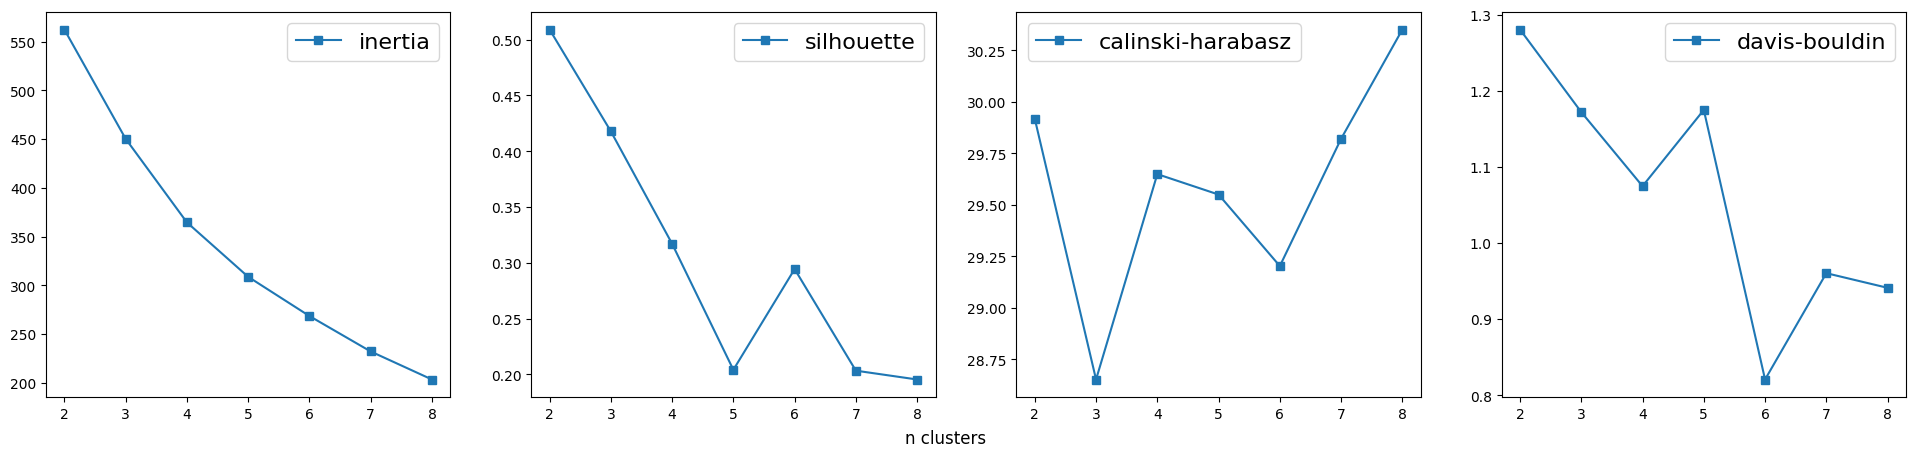

In [64]:
plot_metrics(scaler_df)

"Метод локтя" при оценке инерции и коэффициент Калински-Харабаса указывают на оптимальное колличество кластеров равное 4.Тогда как коэффициент 'силуэта' указывает на 5 кластеров, а коэффициент Дэвиса-Болдина на 6 кластеров. Примем значение числа кластеров равное 4.

Для сбора метрик моделей проекта в таблицу создадим списки моделей и метрик моделей.

Отобразим проекцию  семимерного признакового пространства  на плоскость используя t-SNE преобразование. Кроме того выведем значения кофициентов "силуэта", Калински-Харабаса и Дэвиса-Болдина для колличества кластеров - 4. 

Примем модель Kmeans за базовую для сравнения ее с другими моделями кластеризации. Метрикой оценки модели выберем rand_score (Индекс Рэнда рассчитывает меру сходства между двумя кластерингами,рассматривая все пары выборок и подсчитывая пары,которые приписываются одним и тем же или разным кластерам в предсказанных и истинных кластерингах. )

In [65]:
models=[]  # список моделей, которые я буду использовать в этом проекте
silhouette=[] # список коэффициентов "силуэта" моделей
calinski_harabasz=[] # список коэффициентов Калински-Харабаса моделей
davies_bouldin=[] # список коэффициентов Дэвиса_Болдина моделей
rand=[1.0] # список индексов Рэнда( первое значение будет равно 1 т.к. сходство кластеров модели сама с обой равна 1)

def make_metrics_lists(df,labels):    
    coef_silhouette = silhouette_score(df, labels)  
    coef_calinski_harabasz = calinski_harabasz_score(df, labels)  
    coef_davies_bouldin = davies_bouldin_score(df, labels)
    
    silhouette.append(coef_silhouette)
    calinski_harabasz.append(coef_calinski_harabasz)
    davies_bouldin.append(coef_davies_bouldin)

Коэфициент силуэта: 0.317
Коэфициент Калински-Харабаса: 29.649
Коэфициент Дэвиса-Болдина: 1.075


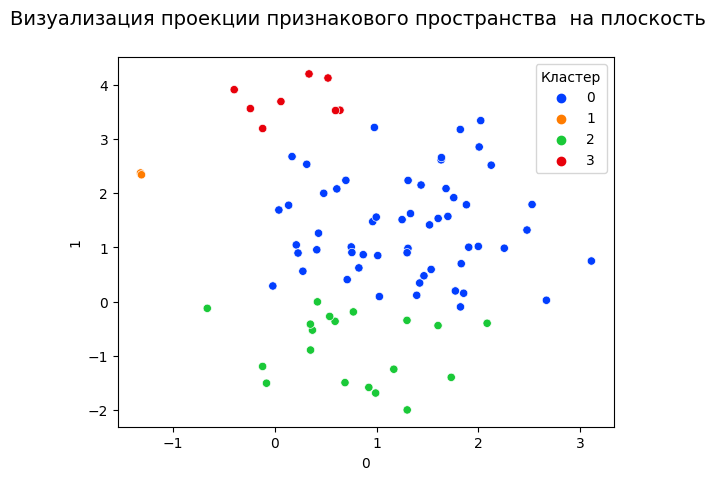

In [66]:
kmeans = KMeans(n_clusters=4, random_state=42)
bm_kmeans = kmeans.fit_predict(scaler_df) # примем модель Kmean за базовую для сравнения с другими

plot_coef(scaler_df, kmeans.labels_)
make_metrics_lists(scaler_df, kmeans.labels_)

models.append(bm_kmeans)

Уменьшим размерность данных методом главных компонент (PCA - principal component analysis). Найдем число главных компонент описывающих 90% дисперсии признакового поля данных. Алгоритм вычисления ***svd_solver*** выберем 'full'

Число главных компонент: 6


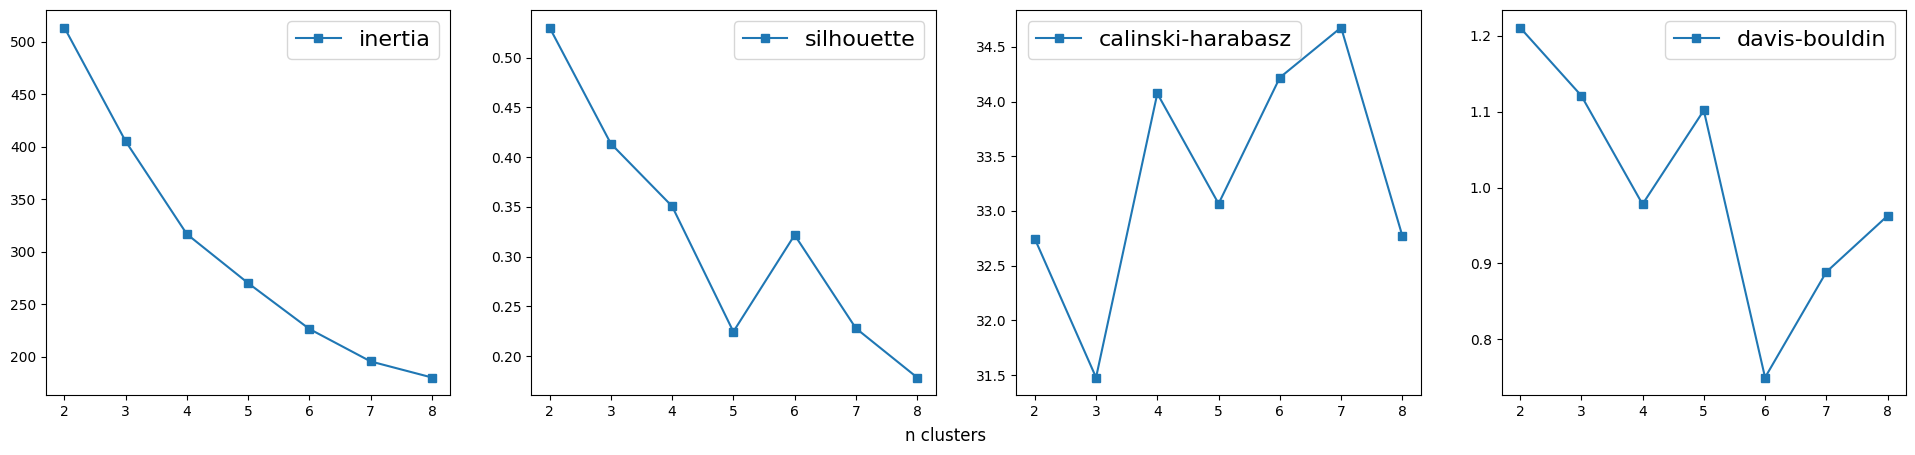

In [67]:
pca = PCA(n_components=0.9, svd_solver='full')
pca_df = pca.fit_transform(scaler_df)

plot_metrics(pca_df)
print(f'Число главных компонент: {pca.n_components_}')

Колличество главных компонент описывающих 90% дисперсии признаков оказалось равным 6. Применение метода главных компонент увеличило величину коэффициентов и незначительно изменило общую картину. Оствляем колличество кластеров равное 4.

Коэфициент силуэта: 0.351
Коэфициент Калински-Харабаса: 34.073
Коэфициент Дэвиса-Болдина: 0.978
Индекс Рэнда (сравнение с базовой моделью): 0.979


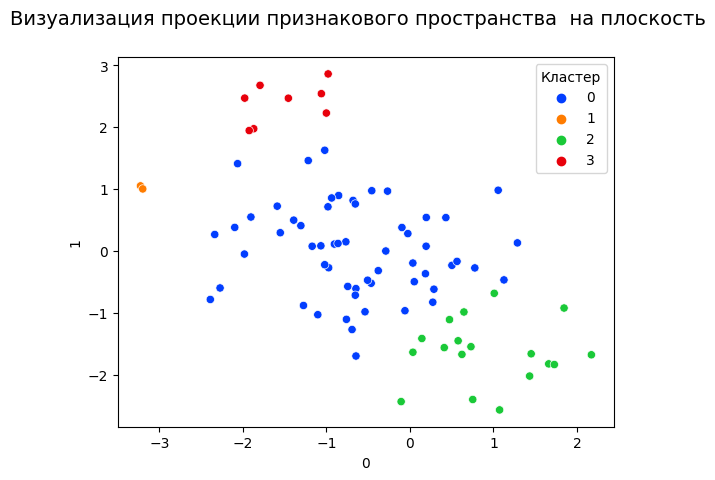

In [68]:
pca_kmeans = KMeans(n_clusters=4, random_state=42)
pca_kmeans.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, pca_kmeans.labels_)

plot_coef(pca_df, pca_kmeans.labels_)
make_metrics_lists(pca_df, pca_kmeans.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(pca_kmeans)
rand.append(index_rand)

### 3. Сравнение с другими алгоритмами кластеризации ###

#### 3.1. Спектральная кластеризация

Коэфициент силуэта: 0.530
Коэфициент Калински-Харабаса: 21.285
Коэфициент Дэвиса-Болдина: 0.961
Индекс Рэнда (сравнение с базовой моделью): 0.676


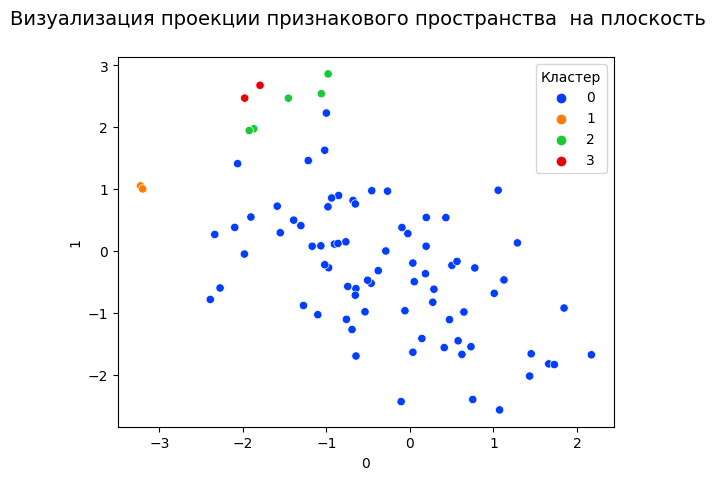

In [69]:
spectral = SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, spectral.labels_)

plot_coef(pca_df, spectral.labels_)
make_metrics_lists(pca_df, spectral.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(spectral)
rand.append(index_rand)

#### 3.2. Агломеративная кластеризация

Коэфициент силуэта: 0.462
Коэфициент Калински-Харабаса: 33.369
Коэфициент Дэвиса-Болдина: 0.925
Индекс Рэнда (сравнение с базовой моделью): 0.803


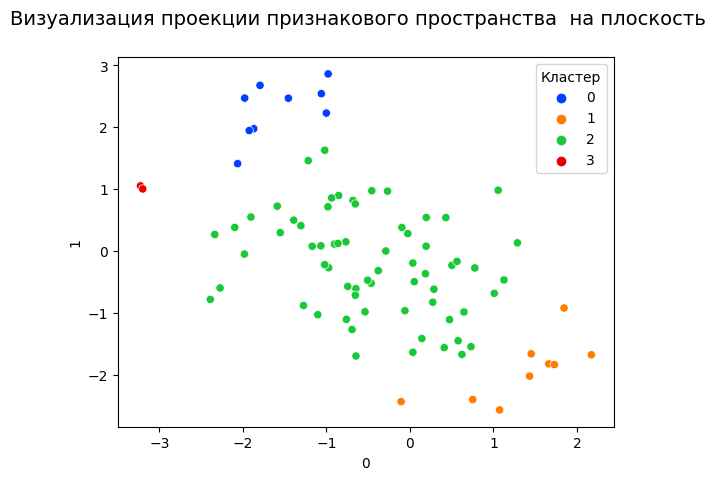

In [70]:
# наилучший вариант: linkage='ward'
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = agg_clust.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, agg_clust.labels_)

plot_coef(pca_df, agg_clust.labels_)
make_metrics_lists(pca_df, agg_clust.labels_)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

#### 3.3. Гауссова смесь

Коэфициент силуэта: 0.154
Коэфициент Калински-Харабаса: 23.001
Коэфициент Дэвиса-Болдина: 1.377
Индекс Рэнда (сравнение с базовой моделью): 0.689


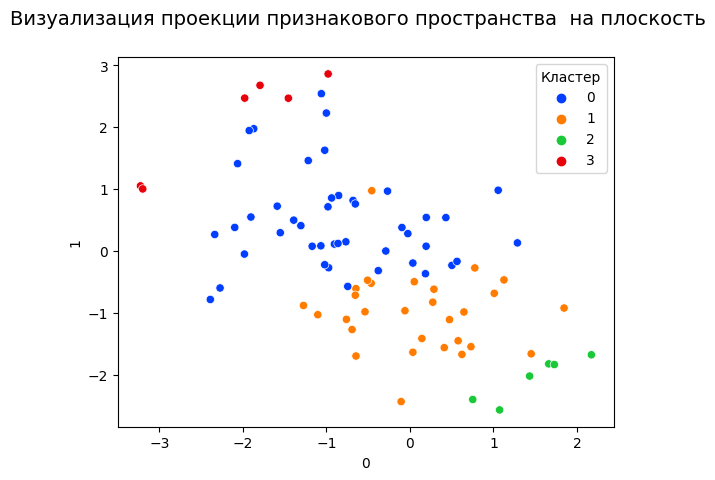

In [71]:
gaus_mix = GaussianMixture(
    n_components=4,
    random_state=42,
    covariance_type='tied'
)
labels = gaus_mix.fit_predict(pca_df)

index_rand = rand_score(bm_kmeans, labels)

plot_coef(pca_df, labels)
make_metrics_lists(pca_df, labels)

print('Индекс Рэнда (сравнение с базовой моделью): %.3f' % index_rand)

models.append(agg_clust)
rand.append(index_rand)

### 4. Итоговая таблица метрик.

Построим для наглядности итоговую таблицу метрик:

In [72]:
d = {'model':['Base Kmeans','Kmeans+PSA', 'SpectralClustering+PCA',
              'AgglomerativeClustering+PCA', 'GaussianMixture+PCA'], 
                                          'Коэф."силуэта"': silhouette,
                                          'Коэф. Калински-Харабаса':calinski_harabasz,
                                          'Коэф. Дэвис-Болдина':davies_bouldin,
                                          'Индекс Рэнда':rand}
metrics_table = pd.DataFrame.from_dict(d, orient='index').T 
metrics_table

,model,"Коэф.""силуэта""",Коэф. Калински-Харабаса,Коэф. Дэвис-Болдина,Индекс Рэнда
0,Base Kmeans,0.317148,29.649195,1.074675,1.0
1,Kmeans+PSA,0.350615,34.073375,0.978146,0.979272
2,SpectralClustering+PCA,0.530454,21.284718,0.961367,0.67619
3,AgglomerativeClustering+PCA,0.462075,33.368761,0.9254,0.803081
4,GaussianMixture+PCA,0.154297,23.000616,1.377182,0.689076


В совокупности метрик кластеризации наилучший результат дает Агломеративноая кластеризация с понижения размерности методом главных компонент. Значение коэффициента "силуэта" достаточно большое среди наибольших значений (0.46), коэффициент Калински-Харабаса один из наибольших, коэфицциент Дэвиса-Болдина имеет минимальное значение.

Альтернативным вариантом кластеризации может являться KMeans с применением понижения размерности методом главных компонент.

### 5. Сохранение модели кластеризации и датафрейма с метками кластеров. ####

In [73]:
 '''В моделе применим следующие этапы:
        - StandardScaler: стандартизация признакового поля данных;
        - PCA: понижение размерности методом главных компонент с сохранением дисперсии признаков 90%;
        - SpectralClustering: спектральная кластеризация.
'''
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.9, svd_solver='full')), ('agg_clust', AgglomerativeClustering(n_clusters=4))])

# сохраним модель в виде pickle-файла
with open('tools/model.pkl', 'wb') as n:
    pickle.dump(pipe, n)
    
# создадим метки кластеров
agg_clust= AgglomerativeClustering(n_clusters=4, linkage='ward')
model_df['cluster'] = agg_clust.fit_predict(pca_df) # метки кластеров

# упорядочим нумерацию кластеров по колличеству регионов
model_df['cluster'] = model_df['cluster'].replace({3:0, 0:1, 2:2, 1:3})

# сохраним датафрейм с метками кластеров
model_df['cluster'].to_csv('./data/labels.csv')

# сохраним метки кластеров
model_df.to_csv('./data/df_labels.csv')

### 6. Характеристика полученных кластеров

In [74]:
model_df.head(3)

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
region,,,,,,,,,,
Алтайский край,13.792906,18.0,291156.9,32067.902020,29.7,153605,17.5,10904,5.9,2
Амурская область,2.182997,17.3,571362.1,43050.621924,21.7,245233,15.2,14331,6.0,2
Архангельская область без Ненецкого АО,2.644435,16.9,514200.4,38856.664512,21.4,250033,12.3,14507,7.4,2


In [75]:
model_df['cluster'].value_counts().sort_index()

0     2
1     9
2    65
3     9
Name: cluster, dtype: int64

In [76]:
# 0 Кластер

cluster_0 = list(model_df[model_df['cluster'] == 0].index)
print (', '.join(cluster_0))


Москва, Санкт-Петербург


In [77]:
model_df[model_df['cluster'] == 0].describe()

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
count,2.000000,2.000000,2.000000e+00,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.0
mean,4398.978084,14.750000,1.269401e+06,16387.219693,18.650000,346084.000000,5.950000,16667.00000,2.750000,0.0
std,779.886114,1.343503,4.217799e+05,9002.478735,1.626346,88515.626869,0.070711,5081.26933,0.212132,0.0
min,3847.515324,13.800000,9.711580e+05,10021.505932,17.500000,283494.000000,5.900000,13074.00000,2.600000,0.0
25%,4123.246704,14.275000,1.120280e+06,13204.362813,18.075000,314789.000000,5.925000,14870.50000,2.675000,0.0
50%,4398.978084,14.750000,1.269401e+06,16387.219693,18.650000,346084.000000,5.950000,16667.00000,2.750000,0.0
75%,4674.709464,15.225000,1.418523e+06,19570.076573,19.225000,377379.000000,5.975000,18463.50000,2.825000,0.0
max,4950.440843,15.700000,1.567645e+06,22752.933454,19.800000,408674.000000,6.000000,20260.00000,2.900000,0.0


In [78]:
# 1 Кластер

cluster_1 = list(model_df[model_df['cluster'] == 1].index)
print (', '.join(cluster_1))

Камчатский край, Магаданская область, Московская область, Ненецкий автономный округ, Республика Саха (Якутия), Сахалинская область, Ханты-Мансийский автономный округ - Югра, Чукотский автономный округ, Ямало-Ненецкий автономный округ


In [79]:
model_df[model_df['cluster'] == 1].describe()

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
count,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,20.505726,15.844444,2.396298e+06,149160.067202,14.033333,261080.777778,9.522222,19711.555556,4.955556,1.0
std,57.400587,2.237248,1.658955e+06,178869.983207,3.795721,50587.355727,3.930260,3433.679008,2.104823,0.0
min,0.069701,13.800000,6.838451e+05,15884.903836,6.400000,202352.000000,4.800000,14586.000000,2.400000,1.0
25%,0.303048,14.100000,1.168152e+06,34439.947894,12.600000,226206.000000,7.700000,17178.000000,3.600000,1.0
50%,0.674204,15.500000,2.035007e+06,124582.304442,14.400000,250679.000000,8.400000,18853.000000,4.400000,1.0
75%,3.131400,16.500000,2.404271e+06,184944.168846,16.500000,263114.000000,9.400000,22535.000000,5.700000,1.0
max,173.495071,20.900000,5.206287e+06,583593.839079,19.400000,347566.000000,17.300000,24711.000000,8.800000,1.0


In [80]:
# 2 Кластер

cluster_2 = list(model_df[model_df['cluster'] == 2].index)
print (', '.join(cluster_2))

Алтайский край, Амурская область, Архангельская область без Ненецкого АО, Астраханская область, Белгородская область, Брянская область, Владимирская область, Волгоградская область, Вологодская область, Воронежская область, Забайкальский край, Ивановская область, Иркутская область, Калининградская область, Калужская область, Кемеровская область, Кировская область, Костромская область, Краснодарский край, Красноярский край, Курганская область, Курская область, Ленинградская область, Липецкая область, Мурманская область, Нижегородская область, Новгородская область, Новосибирская область, Омская область, Оренбургская область, Орловская область, Пензенская область, Пермский край, Приморский край, Псковская область, Республика Адыгея, Республика Башкортостан, Республика Бурятия, Республика Карелия, Республика Коми, Республика Крым, Республика Марий Эл, Республика Мордовия, Республика Северная Осетия-Алания, Республика Татарстан, Республика Хакасия, Ростовская область, Рязанская область, Сама

In [81]:
model_df[model_df['cluster'] == 2].describe()

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
count,65.000000,65.000000,6.500000e+01,65.000000,65.000000,65.000000,65.000000,65.000000,65.000000,65.0
mean,35.446899,17.189231,4.675684e+05,30673.194313,23.527692,197459.800000,13.343077,11944.446154,6.244615,2.0
std,64.649187,1.671930,1.561295e+05,15518.806728,3.792983,36535.345216,3.099948,1620.847059,1.890604,0.0
min,1.050023,13.700000,2.678144e+05,11601.288549,12.600000,127327.000000,6.600000,9834.000000,3.600000,2.0
25%,10.944900,16.200000,3.584804e+05,21241.816509,22.400000,167446.000000,11.600000,10904.000000,5.000000,2.0
50%,27.765516,17.000000,4.596295e+05,25924.555062,23.500000,196888.000000,13.200000,11633.000000,5.900000,2.0
75%,41.800820,18.000000,5.389719e+05,36074.964471,25.500000,226691.000000,15.100000,12425.000000,6.800000,2.0
max,519.835648,24.100000,1.072337e+06,95253.945962,31.400000,277942.000000,20.900000,18438.000000,15.500000,2.0


In [82]:
# 3 Кластер

cluster_3 = list(model_df[model_df['cluster'] == 3].index)
print (', '.join(cluster_3))

Еврейская автономная область, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика, Республика Алтай, Республика Дагестан, Республика Ингушетия, Республика Калмыкия, Республика Тыва, Чеченская Республика


In [83]:
model_df[model_df['cluster'] == 3].describe()

,density,living_area,gdpp,spec_subsidies,welfare,retail,poverty_percent,living_wage,unemployment_rate,cluster
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,47.803985,18.744444,250171.155556,69468.065905,28.433333,118591.555556,23.822222,11739.333333,15.744444,3.0
std,54.703854,4.588603,82201.194441,26565.376886,5.256900,46829.731715,4.939326,1773.523823,6.592441,0.0
min,1.941727,13.600000,142199.700000,43277.951579,19.800000,50713.000000,14.800000,10580.000000,6.300000,3.0
25%,3.628146,14.400000,207471.500000,50558.886180,24.300000,83515.000000,22.700000,10914.000000,14.000000,3.0
50%,32.606850,18.900000,239640.700000,60147.182996,28.300000,123955.000000,23.600000,11138.000000,14.800000,3.0
75%,69.635124,20.200000,283451.400000,81543.922835,32.500000,154476.000000,24.200000,11594.000000,18.000000,3.0
max,162.363433,27.800000,400340.500000,123345.463346,35.100000,188325.000000,31.700000,16336.000000,30.000000,3.0


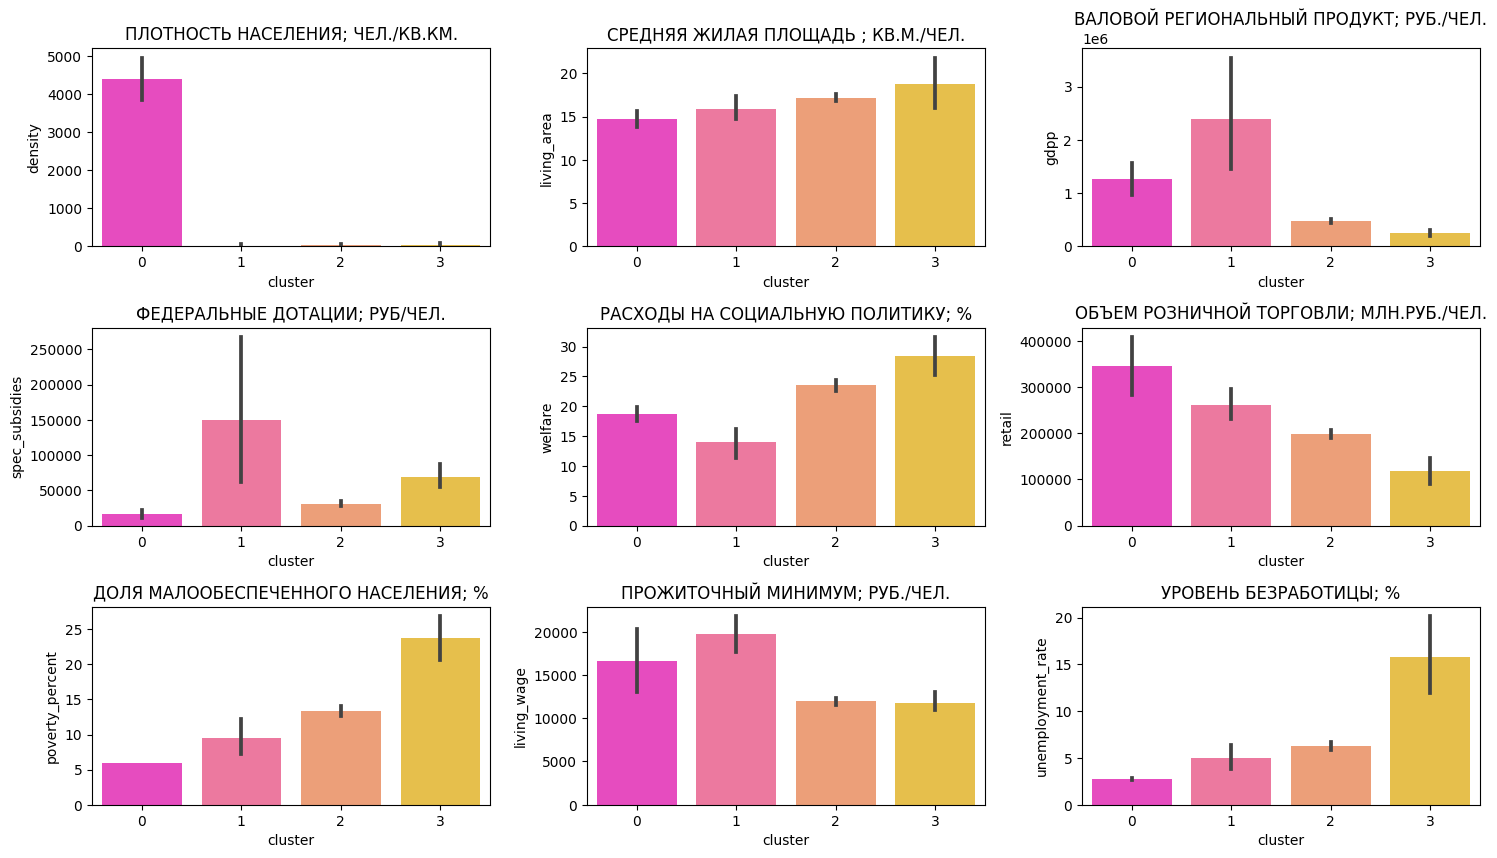

In [84]:
title=['Плотность населения; чел./кв.км.','Средняя жилая площадь ; кв.м./чел.',
       'Валовой региональный продукт; руб./чел.', 'Федеральные дотации; руб/чел.',
       'Расходы на социальную политику; %', 'Объем розничной торговли; млн.руб./чел.',
       'Доля малообеспеченного населения; %', 'Прожиточный минимум; руб./чел.',
       'Уровень безработицы; %']

cols = model_df[
    [
        'density',
        'living_area',
        'gdpp',
        'spec_subsidies',
        'welfare',
        'retail',
        'poverty_percent',
        'living_wage',
        'unemployment_rate'        
    ]
].columns.tolist()
plt.figure(figsize=(15, 25))

for i, variable in enumerate(cols):
    plt.subplot(9, 3, i + 1)
    sns.barplot(model_df['cluster'], model_df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()

Проанализировав статистические характеристики кластеров, сравнив их между собой и для наглядности отобразив их в виде столбчатых диагарамм можно дать следующую характеристику кластерам:

 * ***кластер_0*** - самый небольшой кластер (2 города федерального значения - Москва и Санкт_Петербург), с плотностью населения ( 4399 чел./кв.км. !), с высокими средними показателями дохода, валового регионального продукта на душу населения, самым высоким показателем розничной торговли, минимальной долей населения живущего за чертой бедности,  большими расходами на социальную политику и минимальным уровенем безработицы (2,8 % населения).
 
 * ***кластер_1*** - колличество субъектов - 9, с небольшой плотностью населения (20,5 чел./кв.км.), с самыми высокими средними показателями валового регионального продукта, федеральной дотации, прожиточного минимума, высоким средним показателем розничной торговли, небольшой долей малообеспеченного населения, минимальными расходами на социальную политику и не большим уровенем безработицы (4,9 % населения);
 
 * ***кластер_2*** - самый большой по количеству объектов кластер(65), с плотностью населения (35,4 чел./кв.км.), с средними показателями валового регионального продукта, розничной торговли, доли малообеспеченного населения, большими расходами на социальную политику и не большим уровенем безработицы (6,2 % населения);

 * ***кластер_3*** - колличество субъектов - 9 , с средней плотностью населения ( 47,8 чел./кв.км. !), минимальным показателем валового регионального продукта, розничной торговли, средними показателями федеральных дотаций, прожиточного минимума, очень васокими показателями малообеспеченного населения, расходами на социальную политику  и уровня безработицы (15,7 % населения).

 Исходя из характеристики кластеров можно принять разделение регионов по уровню социальной защищенности:

   * ***кластер_0*** - субъекты сочень высоким уровнем;

   * ***кластер_1*** - субъекты с высоким уровнем;

   * ***кластер_2*** - субъекты с средним уровнем;

   * ***кластер_3*** - субъекты с низким уровнем.

### 7. Проверка гипотез ###

Загрузим датафрейм с 48 признаками, присвоим регионам метки кластеров и сравним значения некоторых признаков между кластерами:

In [85]:
#  загрузим данные проекта в df
df = pd.read_csv(
    '/home/pavel/Work/Skill_Factory_DSPR/GitHub_Projects/Final_Project/Part_1/data/sp_df_2020.csv', index_col='region')

df['cluster'] = model_df['cluster']
df.head(3)



,population,area,living_area,per_capita,real_incomes,formal_wage,real_pay,gdpp,income,subsidies,...,spec_indust,spec_water_supply,spec_provision,spec_reg_prod,childrens_percent,child_orphanage_percent,newborn_1000,child_mortality_1000,disabled_1000,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,2317153,167996,18.0,23864,95.5,30072,103.8,291156.9,56637.879730,74306.235370,...,1.839420e+11,4.511748e+09,1.930862e+10,3.678839e+11,21.153070,0.200551,8.620924,0.041862,26.488540,2
Амурская область,790044,361908,17.3,35499,100.3,52430,105.2,571362.1,51571.555319,34011.885547,...,2.560468e+11,4.393894e+09,5.442775e+10,5.120936e+11,22.619247,0.378283,9.939953,0.053162,31.731144,2
Архангельская область без Ненецкого АО,1092424,413103,16.9,34852,98.4,52779,102.9,514200.4,52963.993010,42447.952872,...,3.039603e+11,5.356946e+09,3.328323e+10,6.079205e+11,20.708809,0.346995,8.152512,0.026546,24.701032,2


#### 7.1. Гипотеза 1 (Влияет ли число детей, пенсионеров и других социально уязвимых групп на уровень бедности в регионе)

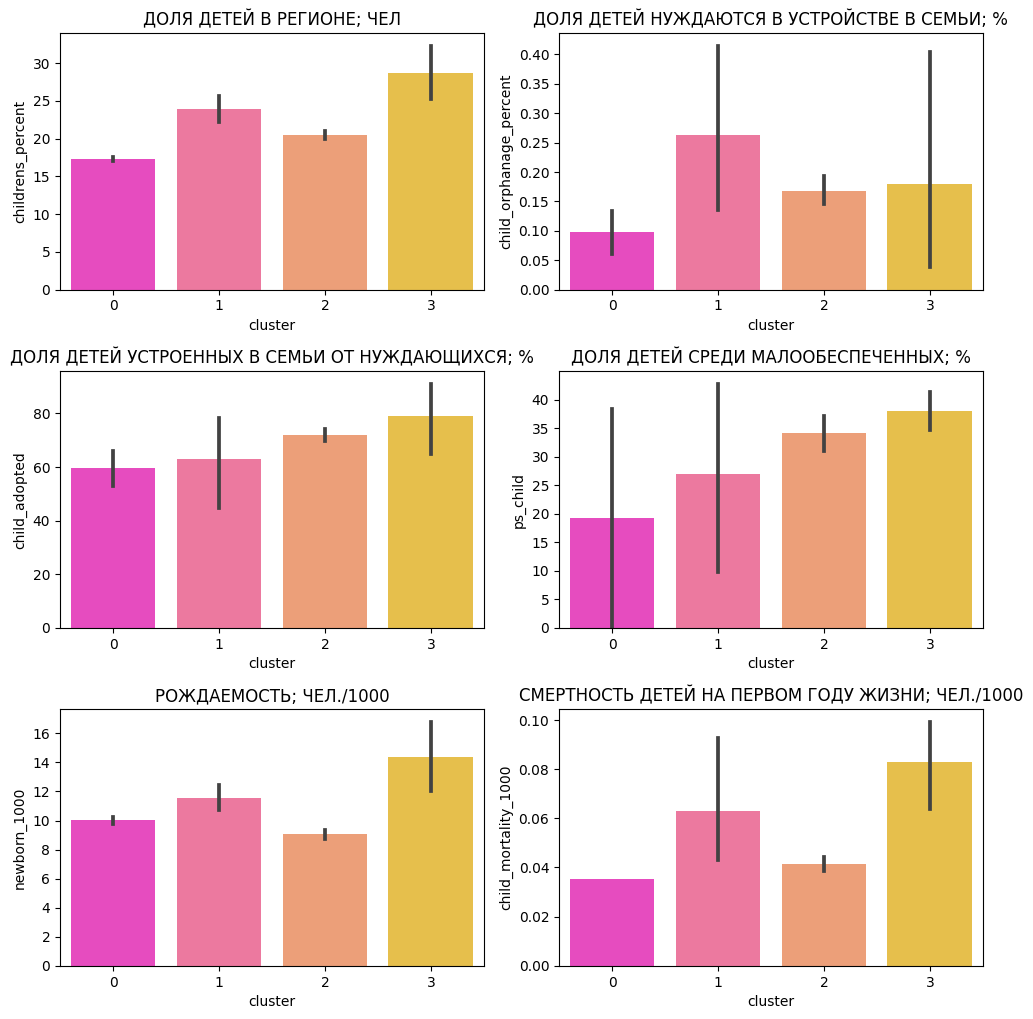

In [86]:
# построим столбчатые диаграмы социальных признаков детей сгруппированных по кластерам

title=['Доля детей в регионе; чел',
       'Доля детей нуждаются в устройстве в семьи; %',
       'Доля детей устроенных в семьи от нуждающихся; %',
       'Доля детей среди малообеспеченных; %',
       'Рождаемость; чел./1000',
       'Смертность детей на первом году жизни; чел./1000',
    ]

cols = df[
    ['childrens_percent',
     'child_orphanage_percent',
     'child_adopted',
     'ps_child',
     'newborn_1000',
     'child_mortality_1000',
    ]
].columns.tolist()
plt.figure(figsize=(10, 20))

for i, variable in enumerate(cols):
    plt.subplot(6, 2, i + 1)
    sns.barplot(df['cluster'], df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()

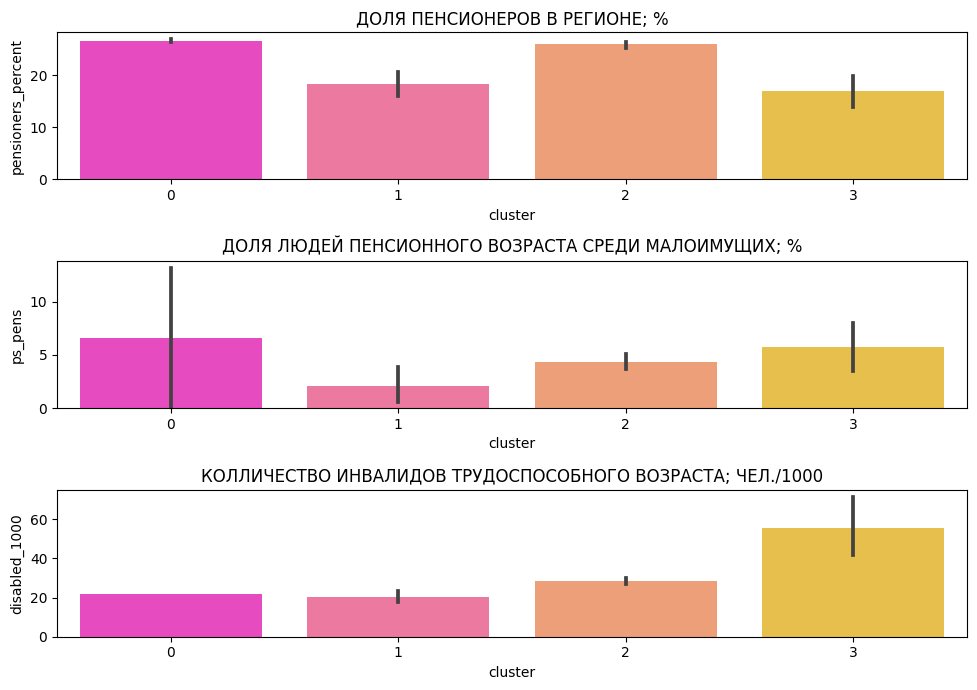

In [90]:
# построим столбчатые диаграмы социальных признаков пенсионеров 
# и ивалидов трудоспособного возраста сгруппированных по кластерам

title=['Доля пенсионеров в регионе; %',
       'Доля людей пенсионного возраста среди малоимущих; %',
       'Колличество инвалидов трудоспособного возраста; чел./1000',
       ]

cols = df[
    ['pensioners_percent',
     'ps_pens',
     'disabled_1000',
    ]
].columns.tolist()
plt.figure(figsize=(10, 7))

for i, variable in enumerate(cols):
    plt.subplot(3, 1, i + 1)
    sns.barplot(df['cluster'], df[variable], palette="spring")
    plt.tight_layout()
    plt.title(title[i].upper())
plt.show()